In [1]:
import torch
import torchvision

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title('Ground Truth: {}'.format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

<Figure size 640x480 with 6 Axes>

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
              (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [12]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.268457
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.268337
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.274000
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.251669
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.236826
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.223578
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153432
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.096480
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.974480
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.944769
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.839859
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.767560
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.698696
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.683217
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.504576
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.390304
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.288033
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.330191
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.279881
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.384248
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.433021
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.451777
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.414984
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.253494
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.284334
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.514462
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.354535
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.379532
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.313661
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.288795
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.426277
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.198716
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.403953
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.398042
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.307750
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.319890
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.353626
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.672196
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.329182


Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.303945
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.221945
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.316206
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.214095
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.242694
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.309853
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.231284
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.110223
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.296089
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.304217
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.142707
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.594734
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.170821
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.432152
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.376709
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.462173
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.329009
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.191146
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.163906
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.195610


Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.213590
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.195273
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.180630
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.215386
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.324156
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.110960
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.226734
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.254021
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.122747
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.111909
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.267069
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.143778
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.087979
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.119822
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.205535
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.200323
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.168124
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.372169
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.120911
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.289359


Train Epoch: 7 [56960/60000 (95%)]	Loss: 0.253197
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.226244
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.085920
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.185656
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.254679

Test set: Avg. loss: 0.0627, Accuracy: 9803/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.146936
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.101490
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.130322
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.266883
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.205843
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.264656
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.273293
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.102989
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.183642
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.085612
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.195048
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.264049
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.142782
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.239861
Train Epoch: 8 [896

Train Epoch: 9 [40960/60000 (68%)]	Loss: 0.186785
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.286238
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.216075
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.410206
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.252168
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.078461
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.144361
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.257568
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.055107
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.197165
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.194257
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.171350
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.433458
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.188261
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.265112
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.234779
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.208667
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.373310
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.223727
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.245094


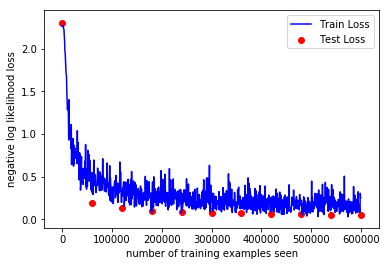

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [15]:
with torch.no_grad():
    output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


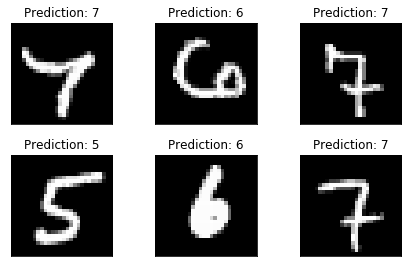

In [16]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
      output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()